# "Анализ мобильного приложения"

Необходимо выполнить ряд задач по исследованию аспектов мобильного приложения:

1. Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).
2. В компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определить, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложить метрики для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import urllib.parse
import requests

In [5]:
# Загрузим данные о времени регистрации
# Загрузка данных
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/tST5wY4FAT1agg'
 
# Получаем загрузочную ссылку
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url) 
download_url = response.json()['href']

# загружаем в датафрейм
reg_data = pd.read_csv(download_url, sep=';')

In [6]:
# посмотрим размер датасета и типы данных
print(reg_data.shape)
print(reg_data.dtypes)

(1000000, 2)
reg_ts    int64
uid       int64
dtype: object


In [7]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [8]:
# Преобразование временной метки в объект datetime
reg_data['reg_date'] = pd.to_datetime(reg_data['reg_ts'], unit='s')

In [9]:
# проверим наличие пропусков
reg_data.isna().sum()

reg_ts      0
uid         0
reg_date    0
dtype: int64

In [10]:
# Загрузим данные о времени захода пользователей в игру
# Загрузка данных
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/9Pfmbzmwlbmlww'
 
# Получаем загрузочную ссылку
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# загружаем в датафрейм
auth_data = pd.read_csv(download_url, sep=';')

In [11]:
# посмотрим размер датафрейма и типы данных
print(auth_data.shape)
print(auth_data.dtypes)

(9601013, 2)
auth_ts    int64
uid        int64
dtype: object


In [13]:
# изменим тип данных
# Преобразование временной метки в объект datetime
auth_data['auth_date'] = pd.to_datetime(auth_data['auth_ts'], unit='s')

In [14]:
# проверим наличие пропусков
auth_data.isna().sum()

auth_ts      0
uid          0
auth_date    0
dtype: int64

### 1.  
Напишем функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [15]:
# Объединяем данные о регистрации с данными о времени захода
merged_data = reg_data.merge(auth_data, on='uid', how='left')

In [16]:
# Проверим на наличие ошибочных значений, когда дата регистрации больше даты авторизации.
merged_data.query('reg_date > auth_date').uid.count()

0

In [17]:
merged_data.dtypes

reg_ts                int64
uid                   int64
reg_date     datetime64[ns]
auth_ts               int64
auth_date    datetime64[ns]
dtype: object

In [18]:
# Определим минимальный и максимальный периоды регистрации и авторизации
print('Минимальный период регистрации игроков:', merged_data.reg_date.min())
print('Максимальный период регистрации игроков:', merged_data.reg_date.max())
print('Минимальный период авторизации игроков:', merged_data.auth_date.min())
print('Максимальный период авторизации игроков:', merged_data.auth_date.max())

Минимальный период регистрации игроков: 1998-11-18 09:43:43
Максимальный период регистрации игроков: 2020-09-23 15:17:24
Минимальный период авторизации игроков: 1998-11-18 09:43:43
Максимальный период авторизации игроков: 2020-09-23 15:17:24


Периоды регистрации и авторизации совпадают.

Посчитаем Retention игроков (по дням от даты регистрации игрока)

In [19]:
# Извлекаем день регистрации игрока
merged_data['cohort_day'] = merged_data['reg_date'].dt.to_period('D')

In [20]:
# Рассчитываем номер периода в днях
merged_data['period_number_day'] = (merged_data.auth_date - merged_data.reg_date).dt.days

In [21]:
merged_data.head()

,reg_ts,uid,reg_date,auth_ts,auth_date,cohort_day,period_number_day
0,911382223,1,1998-11-18 09:43:43,911382223,1998-11-18 09:43:43,1998-11-18,0
1,932683089,2,1999-07-22 22:38:09,932683089,1999-07-22 22:38:09,1999-07-22,0
2,932683089,2,1999-07-22 22:38:09,932921206,1999-07-25 16:46:46,1999-07-22,2
3,932683089,2,1999-07-22 22:38:09,933393015,1999-07-31 03:50:15,1999-07-22,8
4,932683089,2,1999-07-22 22:38:09,933875379,1999-08-05 17:49:39,1999-07-22,13


In [22]:
# Выбираем диапазон значений
start_date = pd.to_datetime("2020-01-01")
end_date = pd.to_datetime("2020-01-31")

In [23]:
# Агрегируем данные по когортам и рассчитанному номеру периода
df_cohort = merged_data.query('reg_date >= @start_date and auth_date <= @end_date') \
                       .groupby(['cohort_day', 'period_number_day'], as_index=False) \
                       .agg(n_customers=('uid', 'nunique'))

In [24]:
# Создаем сводную таблицу для когортного анализа

cohort_pivot = df_cohort.pivot_table(
    index='cohort_day',
    columns='period_number_day',
    values='n_customers'
)

In [25]:
cohort_pivot.head()

period_number_day,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
cohort_day,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1061.0,50.0,38.0,51.0,62.0,77.0,72.0,44.0,43.0,51.0,...,45.0,39.0,40.0,36.0,31.0,32.0,45.0,34.0,40.0,14.0
2020-01-02,1063.0,47.0,47.0,65.0,47.0,70.0,83.0,54.0,55.0,65.0,...,46.0,43.0,43.0,44.0,31.0,46.0,32.0,33.0,20.0,NaN
2020-01-03,1065.0,42.0,38.0,50.0,64.0,85.0,64.0,50.0,46.0,50.0,...,36.0,44.0,32.0,39.0,36.0,36.0,35.0,14.0,NaN,NaN
2020-01-04,1067.0,43.0,49.0,47.0,67.0,73.0,70.0,44.0,46.0,55.0,...,30.0,33.0,36.0,35.0,32.0,25.0,14.0,NaN,NaN,NaN
2020-01-05,1069.0,42.0,48.0,51.0,49.0,69.0,70.0,48.0,50.0,52.0,...,44.0,42.0,41.0,40.0,34.0,20.0,NaN,NaN,NaN,NaN


In [26]:
# Рассчитываем размеры когорт (первый столбец сводной таблицы)
cohort_size = cohort_pivot.iloc[:, 0]

In [27]:
# Вычисляем коэффициенты удержания, деля на размер когорты
retention_matrix = (cohort_pivot.divide(cohort_size, axis=0)).round(3)

In [28]:
retention_matrix.head()

period_number_day,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
cohort_day,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1.0,0.047,0.036,0.048,0.058,0.073,0.068,0.041,0.041,0.048,...,0.042,0.037,0.038,0.034,0.029,0.030,0.042,0.032,0.038,0.013
2020-01-02,1.0,0.044,0.044,0.061,0.044,0.066,0.078,0.051,0.052,0.061,...,0.043,0.040,0.040,0.041,0.029,0.043,0.030,0.031,0.019,NaN
2020-01-03,1.0,0.039,0.036,0.047,0.060,0.080,0.060,0.047,0.043,0.047,...,0.034,0.041,0.030,0.037,0.034,0.034,0.033,0.013,NaN,NaN
2020-01-04,1.0,0.040,0.046,0.044,0.063,0.068,0.066,0.041,0.043,0.052,...,0.028,0.031,0.034,0.033,0.030,0.023,0.013,NaN,NaN,NaN
2020-01-05,1.0,0.039,0.045,0.048,0.046,0.065,0.065,0.045,0.047,0.049,...,0.041,0.039,0.038,0.037,0.032,0.019,NaN,NaN,NaN,NaN


In [29]:
# медианное значение retention на 7 день
retention_matrix[7].median()

0.044

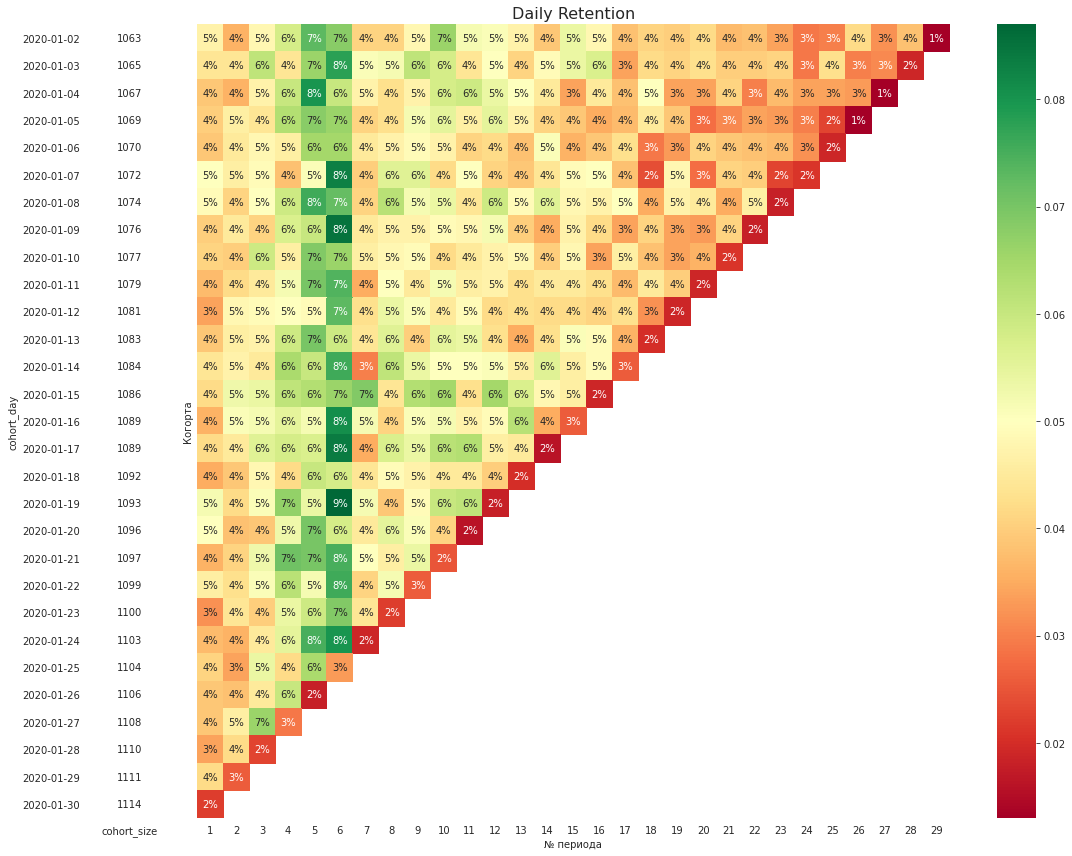

In [30]:
# Строим тепловую карту когортного анализа

# Для лучшей визуализации удаляем нулевой месяц из retention_matrix
retention_matrix_filtered = retention_matrix.iloc[:, 1:]  # Убираем первый столбец (нулевой месяц)
# Удаляем нулевой месяц из cohort_size
cohort_size_filtered = cohort_size[1:]  # Убираем первый элемент (нулевой месяц)

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix_filtered,
                mask=retention_matrix_filtered.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Daily Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size_filtered).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

In [31]:
# Объединим все в функцию
def retention_daily(reg_data, auth_data, start_date, end_date):
    """
    Функция рассчитывает и визуализирует ежедневное удержание для групп пользователей.
    Эта функция объединяет данные регистрации и авторизации, фильтрует их по указанному диапазону дат,
    рассчитывает показатели удержания для каждой ежедневной группы, а затем отображает тепловую карту результатов.

    Параметры:
    reg_data: датасет с метками времени регистрации пользователей. Содержит колонки «uid» и «reg_ts».
    auth_data: датасет с временными метками авторизации пользователя. Содержит колонки «uid» и «auth_ts».
    start_date: дата начала периода анализа в формате «ГГГГ-ММ-ДД».
    end_date: дата окончания периода анализа в формате «ГГГГ-ММ-ДД».

    Возвращает:
    матрицу удержания, показывающую показатель удержания для каждой группы и дня периода.
    Возвращает None, если введенные даты некорректны.
    
    Примечания:
    Функция выводит сообщение «Ошибка: неккоректный ввод дат» и возвращает None, если start_date раньше end_date.
    Отображается тепловая карта, визуализирующая показатели удержания и размеры когорт.
    """   
    
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    if end_date <= start_date:
        print('Ошибка: неккоректный ввод дат')
        return None, None
    
    # Преобразование временной метки в объект datetime
    reg_data['reg_date'] = pd.to_datetime(reg_data['reg_ts'], unit='s')
    auth_data['auth_date'] = pd.to_datetime(auth_data['auth_ts'], unit='s')
    
    merged_data = reg_data.merge(auth_data, on='uid', how='left')
    
    # Извлекаем день регистрации игрока
    merged_data['cohort_day'] = merged_data['reg_date'].dt.to_period('D')
    
    # Рассчитываем номер периода в днях
    merged_data['period_number_day'] = (merged_data.auth_date - merged_data.reg_date).dt.days
    
    # Агрегируем данные по когортам и рассчитанному номеру периода 
    df_cohort = merged_data.query('reg_date >= @start_date and auth_date <= @end_date') \
                           .groupby(['cohort_day', 'period_number_day'], as_index=False) \
                           .agg(n_customers=('uid', 'nunique'))
    
    # Создаем сводную таблицу для когортного анализа
    cohort_pivot = df_cohort.pivot_table(
    index='cohort_day',
    columns='period_number_day',
    values='n_customers'
    )
    
    # Рассчитываем размеры когорт (первый столбец сводной таблицы)
    cohort_size = cohort_pivot.iloc[:, 0]
    # Вычисляем коэффициенты удержания, деля на размер когорты
    retention_matrix = (cohort_pivot.divide(cohort_size, axis=0)).round(3)
    
    # Строим тепловую карту когортного анализа
    # Удаляем нулевой месяц из retention_matrix
    retention_matrix_filtered = retention_matrix.iloc[:, 1:]  # Убираем первый столбец (нулевой месяц)

    # Удаляем нулевой месяц из cohort_size
    cohort_size_filtered = cohort_size[1:]  # Убираем первый элемент (нулевой месяц)

    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix_filtered,
                mask=retention_matrix_filtered.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Daily Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size_filtered).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()
    
    return retention_matrix

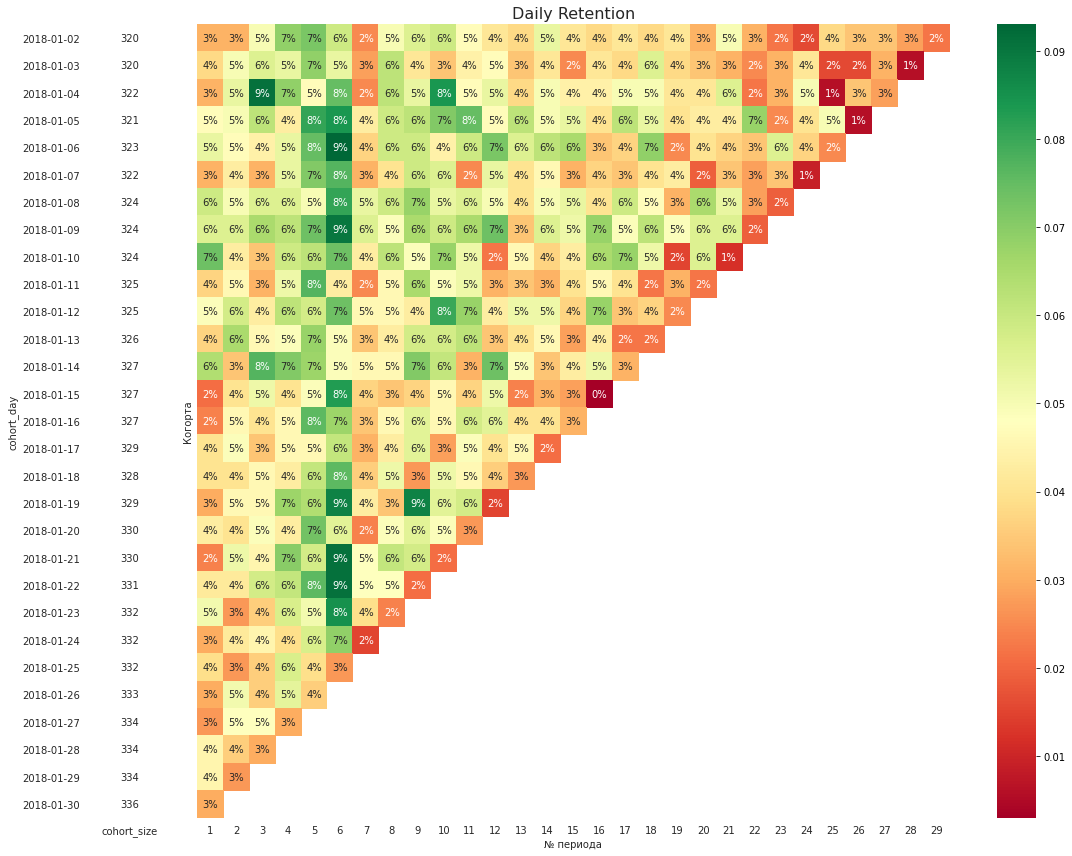

period_number_day,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
cohort_day,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1.0,0.031,0.031,0.050,0.069,0.072,0.059,0.025,0.050,0.056,...,0.031,0.050,0.031,0.022,0.016,0.038,0.034,0.034,0.028,0.022
2018-01-02,1.0,0.038,0.050,0.056,0.053,0.069,0.053,0.028,0.062,0.041,...,0.034,0.031,0.025,0.031,0.041,0.016,0.016,0.031,0.006,NaN
2018-01-03,1.0,0.031,0.053,0.091,0.069,0.047,0.075,0.025,0.062,0.053,...,0.041,0.056,0.022,0.031,0.050,0.006,0.034,0.028,NaN,NaN
2018-01-04,1.0,0.047,0.050,0.062,0.043,0.081,0.084,0.043,0.059,0.062,...,0.043,0.043,0.068,0.025,0.040,0.050,0.006,NaN,NaN,NaN
2018-01-05,1.0,0.053,0.047,0.044,0.053,0.075,0.093,0.037,0.059,0.059,...,0.040,0.037,0.034,0.056,0.037,0.025,NaN,NaN,NaN,NaN
2018-01-06,1.0,0.031,0.043,0.031,0.053,0.071,0.077,0.031,0.040,0.059,...,0.019,0.034,0.028,0.034,0.009,NaN,NaN,NaN,NaN,NaN
2018-01-07,1.0,0.059,0.050,0.056,0.056,0.050,0.081,0.053,0.059,0.068,...,0.065,0.053,0.028,0.019,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,1.0,0.056,0.056,0.065,0.062,0.074,0.090,0.056,0.049,0.065,...,0.056,0.056,0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-09,1.0,0.074,0.043,0.034,0.059,0.062,0.074,0.043,0.062,0.049,...,0.056,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Вызов функции за определенный период
retention_daily(reg_data, auth_data, '2018-01-01', '2018-01-31')

Описание функции **retention_daily**:  
Функция принимает на ввод 4 параметра:  
1. reg_data - датасет с датой регистрации игроков;  
2. auth_data - датасет с датой авторизации игроков;  
3. start_date - строка с датой начала периода для вычисления retention;  
4. end_date - строка с датой окончания периода для вычисления retention.    

### 2  
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [33]:
# Загрузим данных
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/mMRwyESxtFrdmA'
 
# Получаем загрузочную ссылку
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url) 
download_url = response.json()['href']

# загружаем в датафрейм
df = pd.read_csv(download_url, sep=';')

In [34]:
# посмотрим размер датафрейма и типы данных
print(df.shape)
print(df.dtypes)

(404770, 3)
user_id       int64
revenue       int64
testgroup    object
dtype: object


In [35]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [36]:
# проверим наличие пропусков
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

Предоставленнные данные:  
**Контрольная группа:**
- Общее количество пользователей: 202103
- Платящие пользователи: 1928
- ARPU_control  

**Тестовая группа:**
- Общее количество пользователей: 202667
- Платящие пользователи: 1805
- ARPU_test = ARPU_control * 1.05

Необходимо проанализировать следующие метрики:  
1. средний доход на пользователя (Average Revenue Per User - ARPU);
2. средний доход на платящего пользователя (Average Revenue Per Paying User - ARPPU);
3. долю платящих пользователей (Conversion Rate - CR).

1. Средний доход на пользователя (Average Revenue Per User - ARPU)

In [37]:
# Рассчитаем общий доход в каждой группе
total_revenue = df.groupby('testgroup', as_index=False) \
                  .agg(revenue=('revenue', 'sum'))

# Рассчитаем общее количество пользователей в каждой группе
total_users = df.groupby('testgroup', as_index=False) \
                .agg(users=('user_id', 'nunique'))

# Объединим таблицы
df_total = total_revenue.merge(total_users, on='testgroup')

# Рассчитаем ARPU (средний доход на пользователя)
df_total['ARPU'] = df_total['revenue'] / df_total['users']

df_total

,testgroup,revenue,users,ARPU
0,a,5136189,202103,25.413720
1,b,5421603,202667,26.751287


1. Вывод по ARPU:  
Нам известно, что средний доход на пользователя в тестовой группе выше на 5%, чем в контрольной.  
Так как ARPU "b" больше ARPU "a", можем сделать вывод, что "a" - контрольная группа, а "b" - тестовая группа.

2. Cредний доход на платящего пользователя (Average Revenue Per Paying User - ARPPU)

In [38]:
# Рассчитаем количество платящих пользователей в каждой группе
paying_users = df.query('revenue > 0').groupby('testgroup', as_index=False) \
                 .agg(paying_users=('user_id', 'nunique'))

# Объединим таблицы
df_total_1 = df_total.merge(paying_users, on='testgroup')

# Рассчитаем ARPPU (средний доход на платящего пользователя)
df_total_1['ARPPU'] = df_total_1['revenue'] / df_total_1['paying_users']

df_total_1

,testgroup,revenue,users,ARPU,paying_users,ARPPU
0,a,5136189,202103,25.413720,1928,2663.998444
1,b,5421603,202667,26.751287,1805,3003.658172


2. Вывод по ARPPU:  
Средний доход на платящего пользователя в тестовой группе выше (3004), чем в контрольной (2664).  
Новое предложение стимулирует платящих пользователей тратить больше.

3. Доля платящих пользователей (Conversion Rate - CR)

In [39]:
# Рассчитаем CR для контрольной и тестовой групп
df_total_1['CR'] = round(df_total_1['paying_users'] / df_total_1['users'] * 100, 3)

df_total_1

,testgroup,revenue,users,ARPU,paying_users,ARPPU,CR
0,a,5136189,202103,25.413720,1928,2663.998444,0.954
1,b,5421603,202667,26.751287,1805,3003.658172,0.891


3. Вывод по CR:  
Доля платящих пользователей ниже в тестовой группе (0.891%) по сравнению с контрольной (0.954%).  
Новое предложение менее привлекательно для широкой аудитории с точки зрения конверсии в платящего пользователя.

Чтобы убедиться, что различия между группами по данным метрикам неслучайны, необходимо провести статистические тесты.

**1. Средний доход на пользователя (ARPU)**  

In [40]:
# Разделим данные по контрольную и тестовую группы

revenue_control = df[df['testgroup'] == 'a']['revenue']
revenue_test = df[df['testgroup'] == 'b']['revenue']

In [41]:
# Посмотрим статистику в контрольной группе

revenue_control.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [42]:
# Посмотрим статистику в тестовой группе

revenue_test.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

In [43]:
# С помощью теста Левена проверим различаются ли дисперсии в контрольной и тестовой группах
# Нулевая гипотеза (H0): Дисперсии в обеих группах одинаковы.  
# Альтернативная гипотеза (H1): Дисперции в обеих группах различаются.

from scipy import stats
stat, p_value = stats.levene(revenue_control, revenue_test)

print(f"Статистика теста: {stat: .4f}")
print(f"p-значение: {p_value: .4f}")

Статистика теста:  0.3896
p-значение:  0.5325


P-значение > 0.05 (уровень значимости 0,05): Не отклоняем нулевую гипотезу. Статистический тест показывает, разница дисперсий контрольной и тестовой групп не является статистически значимой на уровне 0.05.

Так как выборки контрольной и тестовой групп большие, то начинает работать центральная предельная теорема (ЦПТ) и распределение выборочных средних приближается к нормальному (можно не проверять), поэтому можем применить t-test.

In [44]:
# Нулевая гипотеза (H0): Средний доход на пользователя в обеих группах одинаковый (ARPU_control = ARPU_test).  
# Альтернативная гипотеза (H1): Средний доход на пользователя различается.

# Проведем t-тест для ARPU (с учетом 0 доходов)

t_stat_arpu, p_value_arpu = stats.ttest_ind(revenue_control, revenue_test)

print(f"T-статистика для ARPU: {t_stat_arpu: .2f}")
print(f"P-значение для ARPU: {p_value_arpu: .3f}")

T-статистика для ARPU: -0.62
P-значение для ARPU:  0.532


P-значение > 0.05 (уровень значимости 0,05): Не отклоняем нулевую гипотезу. Несмотря на то, что ARPU в тестовой группе выше на 5%, статистический тест показывает, что наблюдаемая разница в ARPU между контрольной и тестовой группой не является статистически значимой на уровне 0.05. 

**2. Средний доход на платящего пользователя (ARPPU)**  

In [45]:
# Разделим данные по контрольную и тестовую группы для платящих пользователей

paying_revenue_control = revenue_control[revenue_control > 0]
paying_revenue_test = revenue_test[revenue_test > 0]

In [46]:
# Посмотрим статистику в контрольной группе

paying_revenue_control.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [47]:
# Посмотрим статистику в контрольной группе

paying_revenue_test.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

In [48]:
# С помощью теста Левена проверим различаются ли дисперсии в контрольной и тестовой группах
# Нулевая гипотеза (H0): Дисперсии в обеих группах одинаковы.  
# Альтернативная гипотеза (H1): Дисперции в обеих группах различаются.

from scipy import stats
stat, p_value = stats.levene(paying_revenue_control, paying_revenue_test)

print(f"Статистика теста: {stat: .4f}")
print(f"p-значение: {p_value: .4f}")

Статистика теста:  80.8557
p-значение:  0.0000


P-значение < 0.05 (уровень значимости 0,05): Отклоняем нулевую гипотезу. Статистический тест показывает, разница дисперсий контрольной и тестовой групп является статистически значимой.

Так как выборки контрольной и тестовой групп большие, то начинает работать центральная предельная теорема (ЦПТ) и распределение выборочных средних приближается к нормальному (можно не проверять), поэтому можем применить t-test с поправкой Уэлча (так как дисперсии различаются).

In [49]:
# Нулевая гипотеза (H0): Средний доход на платящего пользователя в обеих группах одинаковый (ARPPU_control = ARPPU_test).  
# Альтернативная гипотеза (H1): Средний доход на платящего пользователя различается.

# Проведем t-тест для ARPPU

t_stat_arppu, p_value_arppu = stats.ttest_ind(paying_revenue_control, paying_revenue_test, equal_var=False)

print(f"T-статистика для ARPPU: {t_stat_arppu: .2f}")
print(f"P-значение для ARPPU: {p_value_arppu: .3f}")

T-статистика для ARPPU: -1.64
P-значение для ARPPU:  0.100


P-значение > 0.05 (уровень значимости 0,05): Не отклоняем нулевую гипотезу. Наблюдаемая разница в ARPPU также не является статистически значимой на уровне 0.05. Это означает, что хотя платящие пользователи в тестовой группе платят больше, эта разница может быть случайной.

**3. Доля платящих пользователей (CR)**  
Нулевая гипотеза (H0): Доли конверсии в обеих группах одинаковы (CR_control = CR_test).  
Альтернативная гипотеза (H1): Доли конверсии различаются.

In [50]:
# для анализа зависимости между двумя категориальными переменными будем использовать тест Хи-квадрат (критерий Пирсона)
from scipy.stats import chi2_contingency

paying_control = 1928
total_control = 202103
paying_test = 1805
total_test = 202667

# Расчет неплатящих пользователей
non_paying_control = total_control - paying_control
non_paying_test = total_test - paying_test

# Создание таблицы сопряженности

contingency_table = np.array([
    [paying_control, non_paying_control],
    [paying_test, non_paying_test]
])

# Проведем хи-квадрат тест для CR
chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)

print(f"\nChi2-статистика: {chi2: .2f}")
print(f"P-значение: {p_value: .3f}")
print(f"Степени свободы: {dof}")
print("Ожидаемые частоты (если бы не было разницы):")
print(expected_freq)


Chi2-статистика:  4.37
P-значение:  0.036
Степени свободы: 1
Ожидаемые частоты (если бы не было разницы):
[[  1863.89924896 200239.10075104]
 [  1869.10075104 200797.89924896]]


P-значение < 0.05 (уровень значимости 0,05): Отклоняем нулевую гипотезу. Это означает, что наблюдаемая разница в долях конверсии между группами является статистически значимой. Тестовое предложение статистически значимо снижает конверсию.

Учитывая всю информацию,    
**Тестовое предложение не привело к ожидаемым улучшениям или его эффект слишком мал, чтобы быть обнаруженным с текущими данными:**
- Оно значительно снижает коэффициент конверсии (CR), а значит, меньше людей мотивированы платить.
- Не обнаружено статистически значимого улучшения показателей ARPU или ARPPU, которое могло бы компенсировать эту потерю конверсии.

### 3.  
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

**Метрики для оценки тематического события**
1. Количество участников события. Измеряет общее количество игроков, которые приняли участие в событии. Это поможет понять, насколько событие было привлекательным для игроков.  
2. Процент завершения. Измеряет долю игроков, которые успешно завершили все уровни события. Это показывает, насколько сложным было событие и насколько игроки были вовлечены.    
3.  Среднее время прохождения. Измеряет среднее время, затраченное игроками на завершение всех уровней события. Это покажет, насколько хорошо сбалансированы уровни по сложности и времени.  
4. Количество попыток на уровень. Измеряет среднее количество попыток, которые игроки сделали для прохождения каждого уровня. Это может дать представление о сложности уровней.  
5. Количество полученных наград. Измеряет общее количество уникальных предметов, монет или бонусов, полученных игроками. Это показывает, насколько игроки были мотивированы участвовать в событии.  
6. Обратная связь от игроков. Измеряет оценки и комментарии игроков о событии. Это может дать качественные данные о том, что игрокам понравилось или не понравилось. 

**Метрики для оценки события с усложненной механикой ("откат назад")**  
1. Процент завершения может снизиться. Из-за усложнения механики, большее количество игроков может не завершить событие, что повлияет на общую оценку.  
2. Среднее время прохождения может увеличиться. Игроки могут тратить больше времени на прохождение уровней из-за откатов, что может привести к увеличению среднего времени.  
3. Количество попыток на уровень может возрасти. Игроки могут делать больше попыток, чтобы пройти уровень, что также может указывать на сложность.  
4. Среднее количество откатов. Измеряет среднее количество уровней, на которые игроки откатываются после неудачи. Это поможет понять, насколько сильно усложнение механики влияет на игровой процесс.
5. Изменение в обратной связи от игроков. Игроки могут давать больше отзывов о сложности уровней и механике откатов, что может быть полезно для будущих событий.